# Random forest 

Let's see the accuracy of prediction using a simple random forest. Is using neural networks actually has any advantage?

In [15]:
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
import numpy as np

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Read the csv file into a dataframe

In [16]:
cwd = os.getcwd()
parent = os.path.dirname(cwd)
csv_path = os.path.join(parent, "data/", "master_results.csv")

In [17]:
df = pd.read_csv(csv_path, low_memory=False)
df.head(3)

,p_in,Re,Geometry
0,11.922400,532.38,channelStripRe
1,12.093420,760.11,channelStripRe
2,6.648019,1898.78,leftStripBendRe


In [18]:
df.Geometry = df.Geometry.transform(lambda x: x[:-2])

Let's look at the pressure column

In [19]:
df['p_in'].describe()

count    6.400000e+02
mean     9.761427e+20
std      2.469467e+22
min      2.455772e-01
25%      9.476800e-01
50%      2.528182e+00
75%      7.338899e+00
max      6.247313e+23
Name: p_in, dtype: float64

From the values above we can see that some of the flow cases have not been solved properly by openFOAM. Let's drop all of the unnatural values.

In [20]:
df['p_in'] = np.where(df['p_in'] > 100, False, df['p_in'])
labels = df['p_in'] != False
df = df.loc[labels, :]
df.shape

(625, 3)

In [21]:
df['p_in'].describe()

count    625.000000
mean       5.198978
std        8.167323
min        0.245577
25%        0.926666
50%        2.519571
75%        6.740670
max       88.850320
Name: p_in, dtype: float64

In [22]:
df['p_in'] = np.log1p(df['p_in'])

In [23]:
df['p_in'].describe()

count    625.000000
mean       1.382942
std        0.874236
min        0.219599
25%        0.655791
50%        1.258339
75%        2.046488
max        4.498145
Name: p_in, dtype: float64

In [24]:
df.Geometry.unique()

array(['channelStrip', 'leftStripBend', 'rightStripBend', 'forwardStep',
       'backwardStep', 'narrowEndBend', 'bend', 'channel'], dtype=object)

In [25]:
cats_to_unknown = ['narrowEndBend', 'channel', 'channelStrip']
df.Geometry = df.Geometry.transform(lambda x: x if x not in cats_to_unknown else 'unknown')
df.Geometry

0             unknown
1             unknown
2       leftStripBend
3      rightStripBend
4         forwardStep
            ...      
634       forwardStep
636     leftStripBend
637           unknown
638           unknown
639           unknown
Name: Geometry, Length: 625, dtype: object

In [26]:
# Create derived features from your existing variables

# For Re (Reynolds number)
df['Re_log'] = np.log1p(df['Re'])  # Log transform
df['Re_squared'] = df['Re'] ** 2
df['Re_sqrt'] = np.sqrt(df['Re'])
df['Re_binned'] = pd.cut(df['Re'], bins=20, labels=False)  # Discretize

# Physics-inspired features 
df['Re_inverse'] = 1 / (df['Re'] + 1e-6)
df['Re_range_normalized'] = (df['Re'] - df['Re'].min()) / (df['Re'].max() - df['Re'].min())

# Update continuous variables
cont = ['Re', 'Re_log', 'Re_squared', 'Re_sqrt', 'Re_inverse', 'Re_range_normalized']

In [27]:
procs = [Categorify,  Normalize]
cat = ["Geometry", "Re_binned"]
dep_var = "p_in"

## Random forest

In [28]:
tabular_set = TabularPandas(
    df=df,
    procs=procs,
    cat_names=cat,
    cont_names=cont,
    y_names=dep_var,
    y_block=RegressionBlock(),
)

In [30]:
xs, y = tabular_set.train.xs, tabular_set.train.y
xs.shape, y.shape

((625, 8), (625,))

In [47]:
random_forest = RandomForestRegressor(n_jobs=-1, n_estimators=40,
        max_samples=500, max_features=0.5,
        min_samples_leaf=5, oob_score=True)
random_forest_model = random_forest.fit(xs, y)

In [48]:
random_forest_model.oob_score_

0.23759413775276883

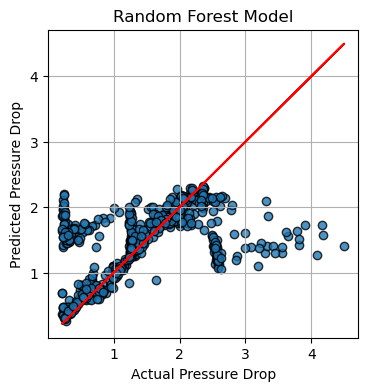

In [50]:
plt.figure(figsize=(4,4))
plt.scatter(y, random_forest_model.oob_prediction_,  alpha=0.8, edgecolors='black')
plt.plot(y, y, color='red')
plt.xlabel("Actual Pressure Drop")
plt.ylabel("Predicted Pressure Drop")
plt.title("Random Forest Model")
plt.grid()
plt.show()

In [51]:
save_pickle('models/randomForestModel.pkl', random_forest_model)